# CAPTCHA Recognition Neural Network Approach

In [1]:
import os
import numpy as np
from matplotlib import pyplot
from matplotlib import image
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

from PIL import Image, ImageOps

In [2]:
filenames = os.listdir('./archive')
labels_text = list(map(lambda x: x.split('.')[0], filenames))
to_tensor = transforms.ToTensor()
images = [
    to_tensor(
        Image.open(f"./archive/{x}")
    ) for x in filenames
]

In [3]:
import string

alphanumeric = {}

i = 0
while i < 10:
    onehot = [0] * 62
    onehot[i] = 1
    alphanumeric[str(i)] = onehot
    i += 1

for c in string.ascii_lowercase:
    onehot = [0] * 62
    onehot[i] = 1
    alphanumeric[c] = onehot
    i += 1

for c in string.ascii_uppercase:
    onehot = [0] * 62
    onehot[i] = 1
    alphanumeric[c] = onehot
    i += 1

labels = []
for l in labels_text:
    label = []
    for c in l:
        label += alphanumeric[c]
    labels.append(torch.tensor(label).float())

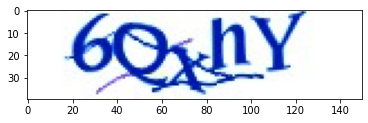

torch.Size([3, 40, 150])

In [4]:
dataset = list(zip(images, labels))

index = 50
pyplot.imshow(dataset[index][0].permute(1, 2, 0))
pyplot.show()
dataset[index][0].shape

In [5]:
import random

random.shuffle(dataset)
div = int(len(dataset) * 0.8)

training_set = dataset[:div]
validation_set = dataset[div:]

In [6]:
class VGG11(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 62 * 5)
    
    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv3(out))
        out = torch.relu(self.conv4(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv5(out))
        out = torch.relu(self.conv6(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv7(out))
        out = torch.relu(self.conv8(out))
        out = F.max_pool2d(out, 2)

        out = out.view(-1, 2048)

        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))

        return out

class CNN_small(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(2880, 1024)
        self.fc2 = nn.Linear(1024, 62 * 5)
    
    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv3(out))
        out = F.max_pool2d(out, 2)

        out = out.view(-1, 2880)

        out = torch.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))

        return out

class CNN_small_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(5760, 62 * 5)
    
    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv3(out))
        out = F.max_pool2d(out, 2)

        out = out.view(-1, 5760)

        out = torch.sigmoid(self.fc1(out))

        return out

In [7]:
model = CNN_small()
model(images[0])

tensor([[0.5041, 0.4951, 0.4941, 0.4937, 0.4984, 0.4950, 0.5095, 0.4989, 0.4983,
         0.4982, 0.4969, 0.4901, 0.4976, 0.4774, 0.5009, 0.4900, 0.5128, 0.5013,
         0.5093, 0.4911, 0.5115, 0.5126, 0.5156, 0.4884, 0.4917, 0.4892, 0.5036,
         0.4873, 0.5060, 0.4944, 0.5070, 0.4881, 0.4974, 0.4968, 0.5273, 0.5022,
         0.4900, 0.5003, 0.4940, 0.4910, 0.5137, 0.5124, 0.5037, 0.4934, 0.4993,
         0.4908, 0.5015, 0.4991, 0.4973, 0.5042, 0.4915, 0.5193, 0.4962, 0.4960,
         0.5091, 0.4867, 0.4902, 0.5013, 0.5165, 0.5111, 0.4863, 0.5020, 0.4968,
         0.5004, 0.5000, 0.5190, 0.5059, 0.5030, 0.5006, 0.4861, 0.5063, 0.5015,
         0.4968, 0.5003, 0.5210, 0.4984, 0.4919, 0.4916, 0.4855, 0.5032, 0.5200,
         0.5160, 0.4988, 0.4904, 0.4836, 0.4936, 0.4915, 0.5138, 0.4894, 0.4934,
         0.4966, 0.5019, 0.4967, 0.5041, 0.4860, 0.5088, 0.4896, 0.5083, 0.5019,
         0.5154, 0.5002, 0.5066, 0.4990, 0.4807, 0.5069, 0.5068, 0.4973, 0.4973,
         0.5021, 0.5001, 0.4

In [8]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    errors = []

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()            
            optimizer.step()
            loss_train += loss.item()
        
        errors.append(loss_train)

        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))
    
    return errors

In [9]:
def extract_label_text(label_tensor):
    charset = "0123456789" + string.ascii_lowercase + string.ascii_uppercase

    chars_onehot = []
    for i in range(0, 310, 62):
        chars_onehot.append(list(label_tensor[i:i+62]))
    
    char_indices = [max(range(len(chars_onehot[i])), key=lambda x: chars_onehot[i][x]) for i in range(len(chars_onehot))]
    text = ''.join([charset[i] for i in char_indices])

    return text

In [10]:
def validate(model, loader):
    correct = 0
    total = 0

    with torch.no_grad():  # <1>
        for imgs, labels in loader:
            outputs = model(imgs)
            total += labels.shape[0]  # <3>

            for i in range(labels.shape[0]):
                if extract_label_text(outputs[i]) == extract_label_text(labels[i]):
                    correct += 1

    return correct / total

In [16]:
train_accuracy = []
val_accuracy = []

for c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False)

    model = CNN_small()
    optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=c)
    loss_fn = nn.CrossEntropyLoss()

    errors = training_loop(
        n_epochs = 10,
        optimizer = optimizer,
        model = model,
        loss_fn = loss_fn,
        train_loader = train_loader
    )
    print(errors)
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=False)
    train_accuracy.append(validate(model, train_loader))
    val_accuracy.append(validate(model, val_loader))

    print(train_accuracy[-1])
    print(val_accuracy[-1])

2022-05-02 16:54:50.798487 Epoch 1, Training loss 28.614225336971494
2022-05-02 16:55:52.251365 Epoch 2, Training loss 28.573719300606413
2022-05-02 16:56:54.592979 Epoch 3, Training loss 28.40162634200159
2022-05-02 16:57:57.658527 Epoch 4, Training loss 27.486761055357007
2022-05-02 16:58:59.020511 Epoch 5, Training loss 26.67076885586372
2022-05-02 17:00:01.232822 Epoch 6, Training loss 26.174998841692208
2022-05-02 17:01:02.135369 Epoch 7, Training loss 25.853706824724693
2022-05-02 17:02:03.921124 Epoch 8, Training loss 25.649837963480724
2022-05-02 17:03:06.144909 Epoch 9, Training loss 25.500160501329646
2022-05-02 17:04:09.646147 Epoch 10, Training loss 25.38244605427038
[80892.41502761841, 80777.90446281433, 80291.3976688385, 77705.07350349426, 75398.26355552673, 73996.72172546387, 73088.4291934967, 72512.09192276001, 72088.95373725891, 71756.17499542236]
0.0026313170958219547
0.0011055587493919428
2022-05-02 17:07:43.650990 Epoch 1, Training loss 28.616878514919005
2022-05-02

In [17]:
print(train_accuracy)
print(val_accuracy)

[0.0026313170958219547, 0.0005306858008380413, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0011055587493919428, 0.00013266704992703312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


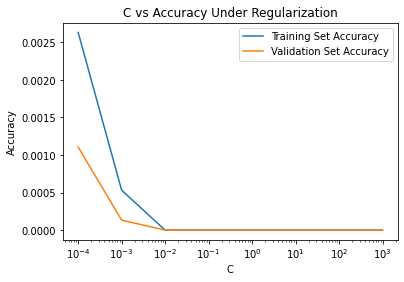

In [19]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

fig, ax = pyplot.subplots()
ax.plot(C, train_accuracy, label="Training Set Accuracy")
ax.plot(C, val_accuracy, label="Validation Set Accuracy")
ax.set_xscale("log")
ax.set_title("C vs Accuracy Under Regularization")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
pyplot.legend()
pyplot.show()